# Model Selection
각 모델들이 공통적으로 걸러낸 부분을 제외하고 어떤 차이를 보이는지 확인하고자 한다. <br>
만들어진 모델들을 불러와, 가장 좋은 효과를 보였던 X set(X_initial or preprocessed_X_initial)에 대해 predict를 진행하고, <br>
공통된 부분을 제외시키고 그 차이를 분석한다. 

## 기본 세팅

### Import

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [35]:
from sklearn import svm
from joblib import dump, load
import xgboost
import pickle
import xgboost as xgb
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

### LC Full Data 불러오기

In [5]:
# 기존 데이터셋 불러오기
lcDataFrame = pd.read_stata('./lendingclub_train.dta')

In [6]:
# 전체 데이터셋을 model들과 동일한 random_state로 sampling

# outlier 빼기
lcDataFrame.drop(lcDataFrame.index[831698], inplace=True)

# 동일한 인덱스끼리 비교하기 위해 동일한 random_state로 train_test_split 후 test set을 합쳐 dfLC로 저장. 
X_train, X_test, y_train, y_test = train_test_split(lcDataFrame.drop(['depvar'], axis=1, inplace=False), lcDataFrame['depvar'], test_size=0.3, random_state=100)
dfLC = pd.concat([X_test, y_test], axis=1)

# 추후 model prediction 결과를 합치기 용이하게 하기 위해 dfLC index 초기화
dfLC = dfLC.reset_index(drop=True)

dfLC

,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0,0,0,0,0,0,0,0.0
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,0,0,0,0,0,0,1,0,0,0.0
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,0,0,0,0,0,0,0,1.0
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0,0,0,0,0,0,0,0.0
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262296,460879,11975,11975,11975.0,0.1952,442.12,95000.0,11.42,0,670,...,0,0,0,0,0,0,0,0,0,0.0
262297,791902,4500,4500,4500.0,0.0976,144.70,82350.0,17.31,2,670,...,0,0,1,0,0,0,0,0,0,0.0
262298,272568,5700,5700,5700.0,0.1399,194.79,22000.0,19.69,0,715,...,0,0,0,0,0,0,0,0,0,0.0
262299,738124,11900,11900,11900.0,0.0790,372.36,37932.0,11.33,0,745,...,0,0,0,0,0,0,0,0,0,0.0


### Prediction에 사용할 X_initial / preprocessed_X_initial 불러오기

In [7]:
def concatTwoDataFrames(df1,df2):
    namesOf2 = df2.columns.tolist()
    for name in namesOf2:
        df1[name] = df2[name]
    return df1

In [8]:
def deleteColumnsFromDataFrame(df, L):
    if type(L) == list:
        newDf = df.drop(columns=[]+L)
    elif type(L) == str:
        newDf = df.drop(columns=[L])
    return newDf

In [9]:
def getDigitList(df, str):
    bucket = []
    for data in df[str]:
        if data != 0:
            bucket.append(1)
        else:
            bucket.append(0)
    return bucket

In [10]:
def eliminateColumn(df, str):
    names_column = df.columns.tolist()
    if str in names_column:
        print('eliminate start ...')
        newDf = df.drop(columns=[str])
        print('eliminate complete.')
        return newDf
    else:
        return df

In [11]:
def getDigitList(df, str):
    bucket = []
    for data in df[str]:
        if data != 0:
            bucket.append(1)
        else:
            bucket.append(0)
    return bucket

In [12]:
def getDigitizedDf(df):
    copyDf = df.copy()  
    names_column = copyDf.columns.tolist()
    names_tobe_digitize = ['delinq_2yrs', 
                           'pub_rec', 
                           'revol_bal', 
                           'collections_12_mths_ex_med', 
                           'pub_rec_bankruptcies', 
                           'tax_liens']
    
    if all(elm in names_column for elm in names_tobe_digitize):
        print('digitize start ...')
        for name in names_tobe_digitize:
            copyDf[name] = getDigitList(copyDf, name)
        print('digitize complete.')
        return copyDf
    else:
        print('digitize failed')
        print('return input data')
        return df

In [13]:
def scaleLog2(df, name):
    bucket = []
    for x in df[name]:
        bucket.append(math.log2(x+1))
    return bucket

In [14]:
def getDataScaledByLog(df):
    copy = df.copy()
    names_tobe_log = ['annual_inc', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']
    print('scale start ...')
    for name in names_tobe_log:
        df[name] = scaleLog2(copy, name)
    print('scale complete.')
    return df

In [15]:
def getInitials(df):
    copy = df.copy()
    names_initial = [
 'loan_amnt',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_high',
 'fico_range_low',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'pub_rec_bankruptcies',
 'tax_liens',
 'term1',
 'emp_length1',
 'emp_length2',
 'emp_length3',
 'emp_length4',
 'emp_length5',
 'emp_length6',
 'emp_length7',
 'emp_length8',
 'emp_length9',
 'emp_length10',
 'emp_length11',
 'emp_length12',
 'home_ownership1',
 'home_ownership2',
 'home_ownership3',
 'home_ownership4',
 'home_ownership5',
 'home_ownership6',
 'purpose1',
 'purpose2',
 'purpose3',
 'purpose4',
 'purpose5',
 'purpose6',
 'purpose7',
 'purpose8',
 'purpose9',
 'purpose10',
 'purpose11',
 'purpose12',
 'purpose13',
 'purpose14',
 'addr_state1',
 'addr_state2',
 'addr_state3',
 'addr_state4',
 'addr_state5',
 'addr_state6',
 'addr_state7',
 'addr_state8',
 'addr_state9',
 'addr_state10',
 'addr_state11',
 'addr_state12',
 'addr_state13',
 'addr_state14',
 'addr_state15',
 'addr_state16',
 'addr_state17',
 'addr_state18',
 'addr_state19',
 'addr_state20',
 'addr_state21',
 'addr_state22',
 'addr_state23',
 'addr_state24',
 'addr_state25',
 'addr_state26',
 'addr_state27',
 'addr_state28',
 'addr_state29',
 'addr_state30',
 'addr_state31',
 'addr_state32',
 'addr_state33',
 'addr_state34',
 'addr_state35',
 'addr_state36',
 'addr_state37',
 'addr_state38',
 'addr_state39',
 'addr_state40',
 'addr_state41',
 'addr_state42',
 'addr_state43',
 'addr_state44',
 'addr_state45',
 'addr_state46',
 'addr_state47',
 'addr_state48',
 'addr_state49',
 'addr_state50',
 'addr_state51',
 'mths_since_last_delinq1',
 'mths_since_last_delinq2',
 'mths_since_last_delinq3',
 'mths_since_last_delinq4',
 'mths_since_last_delinq5',
 'mths_since_last_delinq6',
 'mths_since_last_delinq7',
 'mths_since_last_delinq8',
 'mths_since_last_delinq9',
 'mths_since_last_delinq10',
 'mths_since_last_delinq11',
 'mths_since_last_major_derog1',
 'mths_since_last_major_derog2',
 'mths_since_last_major_derog3',
 'mths_since_last_major_derog4',
 'mths_since_last_major_derog5',
 'mths_since_last_major_derog6',
 'mths_since_last_major_derog7',
 'mths_since_last_major_derog8',
 'mths_since_last_major_derog9',
 'mths_since_last_major_derog10',
 'mths_since_last_major_derog11',
 'mths_since_last_record1',
 'mths_since_last_record2',
 'mths_since_last_record3',
 'mths_since_last_record4',
 'mths_since_last_record5',
 'mths_since_last_record6',
 'mths_since_last_record7',
 'mths_since_last_record8',
 'mths_since_last_record9',
 'mths_since_last_record10',
 'mths_since_last_record11',
 'mths_since_rcnt_il1',
 'mths_since_rcnt_il2',
 'mths_since_rcnt_il3',
 'mths_since_rcnt_il4',
 'mths_since_rcnt_il5',
 'mths_since_rcnt_il6',
 'mths_since_rcnt_il7',
 'mths_since_rcnt_il8',
 'mths_since_rcnt_il9',
 'mths_since_rcnt_il10',
 'mths_since_rcnt_il11',
 'mths_since_recent_bc1',
 'mths_since_recent_bc2',
 'mths_since_recent_bc3',
 'mths_since_recent_bc4',
 'mths_since_recent_bc5',
 'mths_since_recent_bc6',
 'mths_since_recent_bc7',
 'mths_since_recent_bc8',
 'mths_since_recent_bc9',
 'mths_since_recent_bc10',
 'mths_since_recent_bc11',
 'mths_since_recent_bc_dlq1',
 'mths_since_recent_bc_dlq2',
 'mths_since_recent_bc_dlq3',
 'mths_since_recent_bc_dlq4',
 'mths_since_recent_bc_dlq5',
 'mths_since_recent_bc_dlq6',
 'mths_since_recent_bc_dlq7',
 'mths_since_recent_bc_dlq8',
 'mths_since_recent_bc_dlq9',
 'mths_since_recent_bc_dlq10',
 'mths_since_recent_bc_dlq11',
 'mths_since_recent_inq1',
 'mths_since_recent_inq2',
 'mths_since_recent_inq3',
 'mths_since_recent_inq4',
 'mths_since_recent_inq5',
 'mths_since_recent_inq6',
 'mths_since_recent_inq7',
 'mths_since_recent_inq8',
 'mths_since_recent_inq9',
 'mths_since_recent_inq10',
 'mths_since_recent_revol_delinq1',
 'mths_since_recent_revol_delinq2',
 'mths_since_recent_revol_delinq3',
 'mths_since_recent_revol_delinq4',
 'mths_since_recent_revol_delinq5',
 'mths_since_recent_revol_delinq6',
 'mths_since_recent_revol_delinq7',
 'mths_since_recent_revol_delinq8',
 'mths_since_recent_revol_delinq9',
 'mths_since_recent_revol_delinq10',
 'mths_since_recent_revol_delinq11']
    newDf = pd.DataFrame()
    for name in names_initial:
        newDf[name] = copy[name]
    return newDf

In [16]:
def preprocess_initial(rawDataFrame):
    copy = rawDataFrame.copy()
    # initial 변수만 남기기
    df = getInitials(copy)
    # 열 지우기
    df = eliminateColumn(df, 'fico_range_high')
    # 리턴
    return df

In [17]:
def preprocess_scale_digitize(rawDataFrame):
    copy = rawDataFrame.copy()
    # initial 변수만 남기기
    df = getInitials(copy)
    # 열 지우기
    df = eliminateColumn(df, 'fico_range_high')
    # 이진화
    df = getDigitizedDf(df)
    # 로그스케일링
    df = getDataScaledByLog(df)
    # 리턴
    return df

In [18]:
def preprocess_y(rawDataFrame):
    copy = rawDataFrame.copy()
    df = copy[['depvar']]
    return df

In [19]:
X_initial = preprocess_initial(lcDataFrame)

eliminate start ...
eliminate complete.


In [20]:
scaled_digitized_X_initial = preprocess_scale_digitize(lcDataFrame)

eliminate start ...
eliminate complete.
digitize start ...
digitize complete.
scale start ...
scale complete.


In [21]:
y = preprocess_y(lcDataFrame)

In [22]:
X_initial

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,12000,90641.0,10.20,0,690,5,0,5673,0.405,20,...,0,0,0,0,0,0,0,0,0,0
1,14000,46000.0,17.40,1,670,9,0,10285,0.664,18,...,0,0,0,1,0,0,0,0,0,0
2,24000,90000.0,11.73,2,660,6,0,18989,0.474,10,...,0,0,0,0,0,0,0,0,0,0
3,14000,115000.0,7.31,0,660,16,0,16451,0.401,22,...,0,0,0,0,0,0,0,0,0,0
4,14000,78000.0,24.32,0,685,17,0,25930,0.534,30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874330,32000,90000.0,27.39,0,735,14,0,91190,0.813,17,...,0,0,0,0,0,0,0,0,0,0
874331,24000,76000.0,34.20,0,685,16,0,38338,0.844,24,...,0,0,0,0,0,0,0,0,0,0
874332,4000,24960.0,25.29,0,790,15,0,3397,0.092,26,...,0,0,0,0,0,0,0,0,0,0
874333,8000,53000.0,18.07,2,680,10,1,3304,0.370,24,...,0,0,0,1,0,0,0,0,0,0


In [23]:
scaled_digitized_X_initial

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,12000,16.467892,10.20,0,690,2.584963,0.0,1,0.490570,4.392317,...,0,0,0,0,0,0,0,0,0,0
1,14000,15.489378,17.40,1,670,3.321928,0.0,1,0.734655,4.247928,...,0,0,0,1,0,0,0,0,0,0
2,24000,16.457653,11.73,1,660,2.807355,0.0,1,0.559737,3.459432,...,0,0,0,0,0,0,0,0,0,0
3,14000,16.811287,7.31,0,660,4.087463,0.0,1,0.486457,4.523562,...,0,0,0,0,0,0,0,0,0,0
4,14000,16.251205,24.32,0,685,4.169925,0.0,1,0.617298,4.954196,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874330,32000,16.457653,27.39,0,735,3.906891,0.0,1,0.858379,4.169925,...,0,0,0,0,0,0,0,0,0,0
874331,24000,16.213731,34.20,0,685,4.087463,0.0,1,0.882839,4.643856,...,0,0,0,0,0,0,0,0,0,0
874332,4000,14.607388,25.29,0,790,4.000000,0.0,1,0.126973,4.754888,...,0,0,0,0,0,0,0,0,0,0
874333,8000,15.693732,18.07,1,680,3.459432,1.0,1,0.454176,4.643856,...,0,0,0,1,0,0,0,0,0,0


In [24]:
y

,depvar
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
874330,0.0
874331,0.0
874332,0.0
874333,0.0


In [25]:
# 모델에 넣기 위한 test set 생성. 
X_initial_train, X_initial_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.3, random_state=100)

In [26]:
X_initial_test

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
261350,10000,36000.0,27.53,1,665,26,0,5337,0.330,28,...,0,0,0,0,0,0,0,0,0,0
471879,34900,110000.0,16.89,0,690,10,0,29442,0.514,20,...,0,0,0,0,0,0,0,1,0,0
373655,15350,107000.0,6.83,0,680,6,0,2836,0.709,35,...,0,0,0,0,0,0,0,0,0,0
176650,18425,130000.0,6.36,0,690,7,0,9139,0.538,9,...,0,0,0,0,0,0,0,0,0,0
642936,13000,39000.0,16.60,0,720,6,0,4647,0.289,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288695,11975,95000.0,11.42,0,670,7,1,6905,0.460,19,...,0,0,0,0,0,0,0,0,0,0
205338,4500,82350.0,17.31,2,670,7,0,3980,0.206,35,...,0,0,0,1,0,0,0,0,0,0
525344,5700,22000.0,19.69,0,715,17,0,3897,0.120,27,...,0,0,0,0,0,0,0,0,0,0
504579,11900,37932.0,11.33,0,745,6,0,11825,0.422,16,...,0,0,0,0,0,0,0,0,0,0


In [27]:
y_test

,depvar
261350,0.0
471879,0.0
373655,1.0
176650,0.0
642936,0.0
...,...
288695,0.0
205338,0.0
525344,0.0
504579,0.0


In [28]:
dfLC.head()

,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0,0,0,0,0,0,0,0.0
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,0,0,0,0,0,0,1,0,0,0.0
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,0,0,0,0,0,0,0,1.0
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0,0,0,0,0,0,0,0.0
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0,0,0,0,0,0,0,0.0


***

## 모델 Prediction

### 학습을 마친 모델 불러오고 predict

In [33]:
# logistic regression - X_initial
def getPredictByLogitReg(newData):
    with open('my_Logit_model_scaled.pickle', 'rb') as f:
        loaded_model = pickle.load(f)
        y_new_pred = loaded_model.predict(newData)
    return y_new_pred

y_pred = getPredictByLogitReg(X_initial_test)
log_pred = pd.DataFrame(y_pred)
log_pred.rename(columns={0:'log_pred'}, inplace=True)

In [34]:
# random forest - scaled_digitized_X_initial
randF_model = load('RF_initial.joblib')

y_pred = randF_model.predict(X_initial_test)
randF_pred = pd.DataFrame(y_pred)
randF_pred.rename(columns={0:'randF_pred'}, inplace=True)

In [38]:
# svm - X_initial
svm_model = load('svm_initial.joblib')

y_pred = svm_model.predict(X_initial_test)
svm_pred = pd.DataFrame(y_pred)
svm_pred.rename(columns={0:'svm_pred'}, inplace=True)

In [39]:
# svm_lin - X_initial
svm_lin_model = load('SVM(linear)_initial.joblib')

y_pred = svm_lin_model.predict(X_initial_test)
svm_lin_pred = pd.DataFrame(y_pred)
svm_lin_pred.rename(columns={0:'svm_lin_pred'}, inplace=True)

In [40]:
# xgboost - X_initial
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model_0313.bin')
xgb_model_old = xgb_model.load_model('xgb_model.bin')

dtest = xgb.DMatrix(X_initial_test, y_test)
y_pred_probs = xgb_model.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_probs]

xgb_pred = pd.DataFrame(y_pred)
xgb_pred.rename(columns={0:'xgb_pred'}, inplace=True)

In [143]:
xgb_model_over = xgb.Booster()
xgb_model_over.load_model('xgb_model_0313.bin')

### 모델별 Predict 결과 한 DataFrame에 합치기

In [41]:
dfLC = pd.concat([dfLC, log_pred], axis=1)
dfLC = pd.concat([dfLC, randF_pred], axis=1)
dfLC = pd.concat([dfLC, svm_pred], axis=1)
dfLC = pd.concat([dfLC, svm_lin_pred], axis=1)
dfLC = pd.concat([dfLC, xgb_pred], axis=1)

dfLC


,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar,log_pred,randF_pred,svm_pred,svm_lin_pred,xgb_pred
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0,0,0.0,1.0,1.0,1.0,1.0,0
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,0,1,0,0,0.0,1.0,1.0,0.0,1.0,0
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,0,0,1.0,1.0,1.0,0.0,1.0,0
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0,0,0.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262296,460879,11975,11975,11975.0,0.1952,442.12,95000.0,11.42,0,670,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0
262297,791902,4500,4500,4500.0,0.0976,144.70,82350.0,17.31,2,670,...,0,0,0,0,0.0,1.0,1.0,0.0,0.0,0
262298,272568,5700,5700,5700.0,0.1399,194.79,22000.0,19.69,0,715,...,0,0,0,0,0.0,1.0,0.0,1.0,1.0,0
262299,738124,11900,11900,11900.0,0.0790,372.36,37932.0,11.33,0,745,...,0,0,0,0,0.0,1.0,0.0,1.0,1.0,0


---

## 결과 분석
### by loss amount
depvar == 1 인 경우에 대해, 모델 별로 loss_amnt 계산 <br>

In [42]:
for t in dfLC["term1"]:
    if t == 0:
        dfLC["loss_amnt"] = dfLC["installment"]*60-dfLC["total_pymnt"]
    else:
        dfLC["loss_amnt"] = dfLC["installment"]*36-dfLC["total_pymnt"]

In [43]:
# Logistic Regression
log_dfLC = dfLC.loc[dfLC["depvar"]==1]
TP_log_dfLC = log_dfLC.loc[(log_dfLC["depvar"]==1) & (log_dfLC["log_pred"]==0)]

In [44]:
# Random Forest stochastic Gradient Descent
randF_dfLC = dfLC.loc[dfLC["depvar"]==1]
TP_randF_dfLC = randF_dfLC.loc[(randF_dfLC["depvar"]==1) & (randF_dfLC["randF_pred"]==0)]

In [45]:
# SVM
svm_dfLC = dfLC.loc[dfLC["depvar"]==1]
TP_svm_dfLC = svm_dfLC.loc[(svm_dfLC["depvar"]==1) & (svm_dfLC["svm_pred"]==0)]

In [46]:
# svm_lin
svm_lin_dfLC = dfLC.loc[dfLC["depvar"]==1]
TP_svm_lin_dfLC = svm_lin_dfLC.loc[(svm_lin_dfLC["depvar"]==1) & (svm_lin_dfLC["svm_pred"]==0)]

In [47]:
# XGBoost
xgb_dfLC = dfLC.loc[dfLC["depvar"]==1]
TP_xgb_dfLC = xgb_dfLC.loc[(xgb_dfLC["depvar"]==1) & (xgb_dfLC["xgb_pred"]==0)]

loss_amnt를 x축으로 하고, 각 모델의 색을 다르게 해서 histogram을 그린다. 

파산했고(depvar==1), 옳게 예측(pred==1)한 건(True Positive)에 대해서 동일한 그래프를 다시 그려본다. 

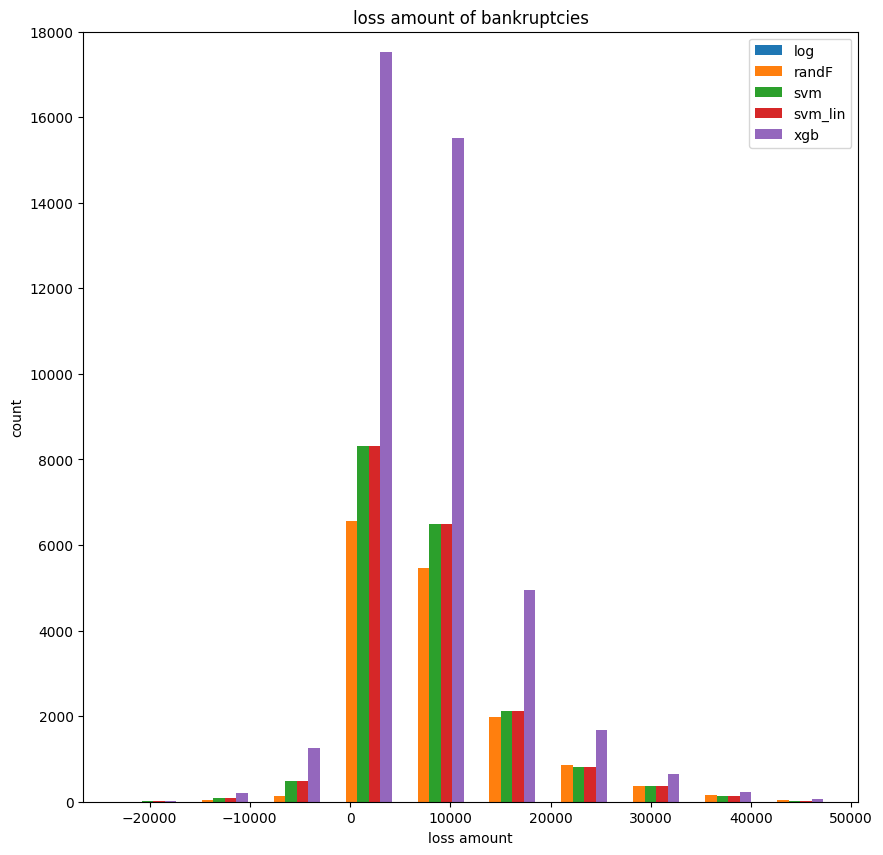

In [49]:
plt.figure(figsize=(10,10))
#plt.hist(TP_xgb_dfLC["loss_amnt"], bins=10)
plt.hist((TP_log_dfLC["loss_amnt"], TP_randF_dfLC["loss_amnt"], TP_svm_dfLC["loss_amnt"], TP_svm_lin_dfLC["loss_amnt"], TP_xgb_dfLC["loss_amnt"]), label=('log', 'randF', 'svm', 'svm_lin', 'xgb'), histtype='bar')
plt.xlabel('loss amount')
plt.ylabel('count')
plt.ylim([0,18000])
plt.legend()
plt.title("loss amount of bankruptcies")

plt.show()

### 모든 모델이 동일하게 판단하는 항 제거 후 loss amount 비교

In [50]:
dfLC_difference = dfLC.loc[dfLC["depvar"]+dfLC["log_pred"]+dfLC["randF_pred"]+dfLC["svm_pred"]+dfLC["svm_lin_pred"]+dfLC["xgb_pred"]!=6]
#dfLC_difference = dfLC.loc[dfLC["depvar"]+dfLC["xgb_pred"]!=2]

dfLC_difference

,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar,log_pred,randF_pred,svm_pred,svm_lin_pred,xgb_pred,loss_amnt
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0,0.0,1.0,1.0,1.0,1.0,0,0.256370
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,1,0,0,0.0,1.0,1.0,0.0,1.0,0,-10418.028600
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,0,1.0,1.0,1.0,0.0,1.0,0,4391.570000
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0,0.0,1.0,1.0,0.0,0.0,0,-11837.600530
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0,0.0,1.0,1.0,1.0,1.0,0,-7030.105170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262296,460879,11975,11975,11975.0,0.1952,442.12,95000.0,11.42,0,670,...,0,0,0,0.0,1.0,0.0,0.0,0.0,0,822.830000
262297,791902,4500,4500,4500.0,0.0976,144.70,82350.0,17.31,2,670,...,0,0,0,0.0,1.0,1.0,0.0,0.0,0,13.273751
262298,272568,5700,5700,5700.0,0.1399,194.79,22000.0,19.69,0,715,...,0,0,0,0.0,1.0,0.0,1.0,1.0,0,1103.904002
262299,738124,11900,11900,11900.0,0.0790,372.36,37932.0,11.33,0,745,...,0,0,0,0.0,1.0,0.0,1.0,1.0,0,240.000000


In [51]:
# Logistic Regression
diff_log_dfLC = dfLC_difference.loc[dfLC_difference["depvar"]==1]
diff_TP_log_dfLC = diff_log_dfLC.loc[(diff_log_dfLC["depvar"]==1) & (diff_log_dfLC["log_pred"]==0)]

In [52]:
# Random Forest
diff_randF_dfLC = dfLC_difference.loc[dfLC_difference["depvar"]==1]
diff_TP_randF_dfLC = diff_randF_dfLC.loc[(diff_randF_dfLC["depvar"]==1) & (diff_randF_dfLC["randF_pred"]==0)]

In [53]:
# SVM
diff_svm_dfLC = dfLC_difference.loc[dfLC_difference["depvar"]==1]
diff_TP_svm_dfLC = diff_svm_dfLC.loc[(diff_svm_dfLC["depvar"]==1) & (diff_svm_dfLC["svm_pred"]==0)]

In [54]:
# svm_lin
diff_svm_lin_dfLC = dfLC_difference.loc[dfLC_difference["depvar"]==1]
diff_TP_svm_lin_dfLC = diff_svm_lin_dfLC.loc[(diff_svm_lin_dfLC["depvar"]==1) & (diff_svm_lin_dfLC["svm_pred"]==0)]

In [55]:
# XGBoost
diff_xgb_dfLC = dfLC_difference.loc[dfLC_difference["depvar"]==1]
diff_TP_xgb_dfLC = diff_xgb_dfLC.loc[(diff_xgb_dfLC["depvar"]==1) & (diff_xgb_dfLC["xgb_pred"]==0)]

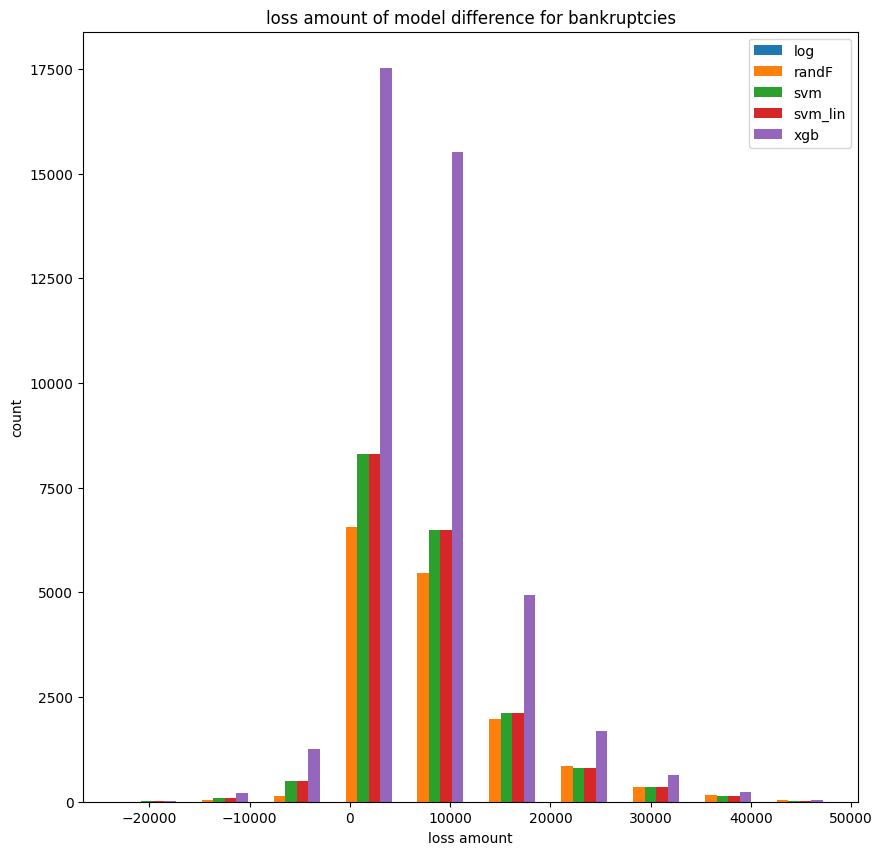

In [56]:
plt.figure(figsize=(10,10))

#plt.hist(dfLC_difference.loc[dfLC_difference["depvar"]==1]["loss_amnt"], bins=10)
plt.hist((diff_TP_log_dfLC["loss_amnt"], diff_TP_randF_dfLC["loss_amnt"], diff_TP_svm_dfLC["loss_amnt"], diff_TP_svm_lin_dfLC["loss_amnt"], diff_TP_xgb_dfLC["loss_amnt"]), label=('log', 'randF', 'svm', 'svm_lin', 'xgb'), histtype='bar')
plt.xlabel('loss amount')
plt.ylabel('count')
plt.legend()
plt.title("loss amount of model difference for bankruptcies")

plt.show()

In [ ]:
# LC의 손실액과 우리 모델의 손실액 비교

In [57]:
lossOfLC = dfLC["depvar"]*dfLC["loss_amnt"]
print("Loss amount of LC")
lossOfLC.sum()

Loss amount of LC


298839515.232491

In [58]:
lossOflog = (log_dfLC['depvar']-log_dfLC["log_pred"])*log_dfLC["loss_amnt"]
print("Loss amount of Logistic Regression")
lossOflog.sum()

Loss amount of Logistic Regression


0.0

In [63]:
lossOfxgb = (xgb_dfLC['depvar']-xgb_dfLC["xgb_pred"])*xgb_dfLC["loss_amnt"]
print("Loss amount of XGBoost")
lossOfxgb.sum()

Loss amount of XGBoost


295806622.392231

In [60]:
lossOfrandF = (randF_dfLC['depvar']-randF_dfLC["randF_pred"])*randF_dfLC["loss_amnt"]
print("Loss amount of Random Forest")
lossOfrandF.sum()

Loss amount of Random Forest


124410447.042117

In [61]:
lossOfsvm = (svm_dfLC['depvar']-svm_dfLC["svm_pred"])*svm_dfLC["loss_amnt"]
print("Loss amount of SVM")
lossOfsvm.sum()

Loss amount of SVM


133530653.56357901

In [62]:
lossOfsvm_lin = (svm_lin_dfLC['depvar']-svm_lin_dfLC["svm_lin_pred"])*svm_lin_dfLC["loss_amnt"]
lossOfsvm_lin.sum()

102556629.542863

## 결과 분석
### by implicit loss amount
#### 파산하지 않았으나 파산으로 예측하여 잃게되는 손실
depvar == 0 인 경우에 대해, 모델 별로 loss_amnt_implicit 계산 <br>
* term1 == 36인 건밖에 없음. 

In [73]:
dfLC

,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar,log_pred,randF_pred,svm_pred,svm_lin_pred,xgb_pred,loss_amnt,loss_amnt_implicit
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0.0,1.0,1.0,1.0,1.0,0,0.256370,2477.703630
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,0,0,0.0,1.0,1.0,0.0,1.0,0,-10418.028600,6265.268600
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,1.0,1.0,1.0,0.0,1.0,0,4391.570000,-6417.610000
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0.0,1.0,1.0,0.0,0.0,0,-11837.600530,11353.560530
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0.0,1.0,1.0,1.0,1.0,0,-7030.105170,5805.345170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262296,460879,11975,11975,11975.0,0.1952,442.12,95000.0,11.42,0,670,...,0,0,0.0,1.0,0.0,0.0,0.0,0,822.830000,3118.490000
262297,791902,4500,4500,4500.0,0.0976,144.70,82350.0,17.31,2,670,...,0,0,0.0,1.0,1.0,0.0,0.0,0,13.273751,695.926249
262298,272568,5700,5700,5700.0,0.1399,194.79,22000.0,19.69,0,715,...,0,0,0.0,1.0,0.0,1.0,1.0,0,1103.904002,208.535998
262299,738124,11900,11900,11900.0,0.0790,372.36,37932.0,11.33,0,745,...,0,0,0.0,1.0,0.0,1.0,1.0,0,240.000000,1264.960000


In [74]:
dfLC["loss_amnt_implicit"] = dfLC["total_pymnt"] - dfLC['loan_amnt']

In [75]:
# Logistic Regression
log_dfLC_implicit = dfLC.loc[dfLC["depvar"]==0]
TP_log_dfLC_implicit = log_dfLC_implicit.loc[(log_dfLC_implicit["depvar"]==0) & (log_dfLC_implicit["log_pred"]==1)]

In [76]:
# Random Forest
randF_dfLC_implicit = dfLC.loc[dfLC["depvar"]==0]
TP_randF_dfLC_implicit = randF_dfLC_implicit.loc[(randF_dfLC_implicit["depvar"]==0) & (randF_dfLC_implicit["randF_pred"]==1)]

In [77]:
# SVM
svm_dfLC_implicit = dfLC.loc[dfLC["depvar"]==0]
TP_svm_dfLC_implicit = svm_dfLC_implicit.loc[(svm_dfLC_implicit["depvar"]==0) & (svm_dfLC_implicit["svm_pred"]==1)]

In [78]:
# svm_lin
svm_lin_dfLC_implicit = dfLC.loc[dfLC["depvar"]==0]
TP_svm_lin_dfLC_implicit = svm_lin_dfLC_implicit.loc[(svm_lin_dfLC_implicit["depvar"]==0) & (svm_lin_dfLC_implicit["svm_lin_pred"]==1)]

In [79]:
# XGBoost
xgb_dfLC_implicit = dfLC.loc[dfLC["depvar"]==0]
TP_xgb_dfLC_implicit = xgb_dfLC_implicit.loc[(xgb_dfLC_implicit["depvar"]==0) & (xgb_dfLC_implicit["xgb_pred"]==1)]

loss_amnt_implicit를 x축으로 하고, 각 모델의 색을 다르게 해서 histogram을 그린다. 

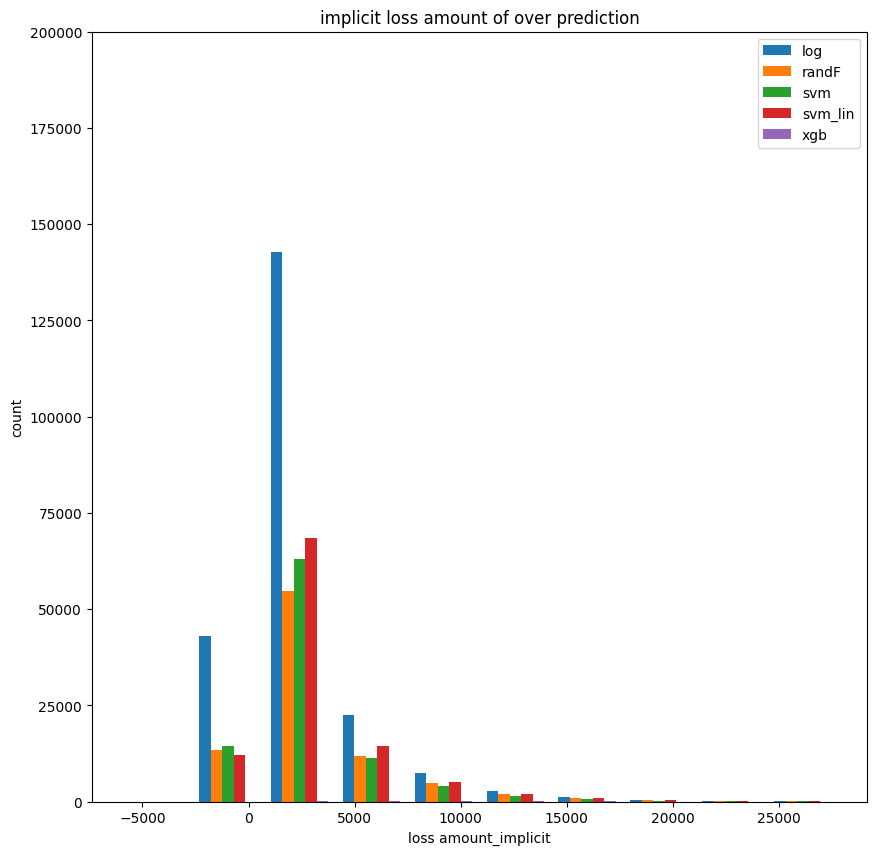

In [80]:
plt.figure(figsize=(10,10))
#plt.hist(TP_xgb_dfLC["loss_amnt"], bins=10)
plt.hist((TP_log_dfLC_implicit["loss_amnt_implicit"], TP_randF_dfLC_implicit["loss_amnt_implicit"], TP_svm_dfLC_implicit["loss_amnt_implicit"], TP_svm_lin_dfLC_implicit["loss_amnt_implicit"], TP_xgb_dfLC_implicit["loss_amnt_implicit"]), label=('log', 'randF', 'svm', 'svm_lin', 'xgb'), histtype='bar')
plt.xlabel('loss amount_implicit')
plt.ylabel('count')
plt.ylim([0,200000])
plt.legend()
plt.title("implicit loss amount of over prediction")

plt.show()

### 모든 모델이 동일하게 판단하는 항 제거 후 loss amount 비교

In [81]:
dfLC_difference_implicit = dfLC.loc[dfLC["depvar"]+dfLC["log_pred"]+dfLC["randF_pred"]+dfLC["svm_pred"]+dfLC["svm_lin_pred"]+dfLC["xgb_pred"]!=0]
#dfLC_difference = dfLC.loc[dfLC["depvar"]+dfLC["xgb_pred"]!=2]

dfLC_difference_implicit

,index,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11,depvar,log_pred,randF_pred,svm_pred,svm_lin_pred,xgb_pred,loss_amnt,loss_amnt_implicit
0,647275,10000,10000,10000.0,0.1499,346.61,36000.0,27.53,1,665,...,0,0,0.0,1.0,1.0,1.0,1.0,0,0.256370,2477.703630
1,521541,34900,34900,34625.0,0.1629,854.09,110000.0,16.89,0,690,...,0,0,0.0,1.0,1.0,0.0,1.0,0,-10418.028600,6265.268600
2,731381,15350,15350,15350.0,0.1561,370.11,107000.0,6.83,0,680,...,0,0,1.0,1.0,1.0,0.0,1.0,0,4391.570000,-6417.610000
3,664187,18425,18425,18425.0,0.2099,498.36,130000.0,6.36,0,690,...,0,0,0.0,1.0,1.0,0.0,0.0,0,-11837.600530,11353.560530
4,1048325,13000,13000,12975.0,0.1757,327.09,39000.0,16.60,0,720,...,0,0,0.0,1.0,1.0,1.0,1.0,0,-7030.105170,5805.345170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262296,460879,11975,11975,11975.0,0.1952,442.12,95000.0,11.42,0,670,...,0,0,0.0,1.0,0.0,0.0,0.0,0,822.830000,3118.490000
262297,791902,4500,4500,4500.0,0.0976,144.70,82350.0,17.31,2,670,...,0,0,0.0,1.0,1.0,0.0,0.0,0,13.273751,695.926249
262298,272568,5700,5700,5700.0,0.1399,194.79,22000.0,19.69,0,715,...,0,0,0.0,1.0,0.0,1.0,1.0,0,1103.904002,208.535998
262299,738124,11900,11900,11900.0,0.0790,372.36,37932.0,11.33,0,745,...,0,0,0.0,1.0,0.0,1.0,1.0,0,240.000000,1264.960000


In [82]:
# Logistic Regression
diff_log_dfLC_implicit = dfLC_difference_implicit.loc[dfLC_difference_implicit["depvar"]==0]
diff_TP_log_dfLC_implicit = diff_log_dfLC_implicit.loc[(diff_log_dfLC_implicit["depvar"]==0) & (diff_log_dfLC_implicit["log_pred"]==1)]

In [83]:
# Random Forest
diff_randF_dfLC_implicit = dfLC_difference_implicit.loc[dfLC_difference_implicit["depvar"]==0]
diff_TP_randF_dfLC_implicit = diff_randF_dfLC_implicit.loc[(diff_randF_dfLC_implicit["depvar"]==0) & (diff_randF_dfLC_implicit["randF_pred"]==1)]

In [84]:
# SVM
diff_svm_dfLC_implicit = dfLC_difference_implicit.loc[dfLC_difference_implicit["depvar"]==0]
diff_TP_svm_dfLC_implicit = diff_svm_dfLC_implicit.loc[(diff_svm_dfLC_implicit["depvar"]==0) & (diff_svm_dfLC_implicit["svm_pred"]==1)]

In [85]:
# svm_lin
diff_svm_lin_dfLC_implicit = dfLC_difference_implicit.loc[dfLC_difference_implicit["depvar"]==0]
diff_TP_svm_lin_dfLC_implicit = diff_svm_lin_dfLC_implicit.loc[(diff_svm_lin_dfLC_implicit["depvar"]==0) & (diff_svm_lin_dfLC_implicit["svm_lin_pred"]==1)]

In [86]:
# XGBoost
diff_xgb_dfLC_implicit = dfLC_difference_implicit.loc[dfLC_difference_implicit["depvar"]==0]
diff_TP_xgb_dfLC_implicit = diff_xgb_dfLC_implicit.loc[(diff_xgb_dfLC_implicit["depvar"]==0) & (diff_xgb_dfLC_implicit["xgb_pred"]==1)]

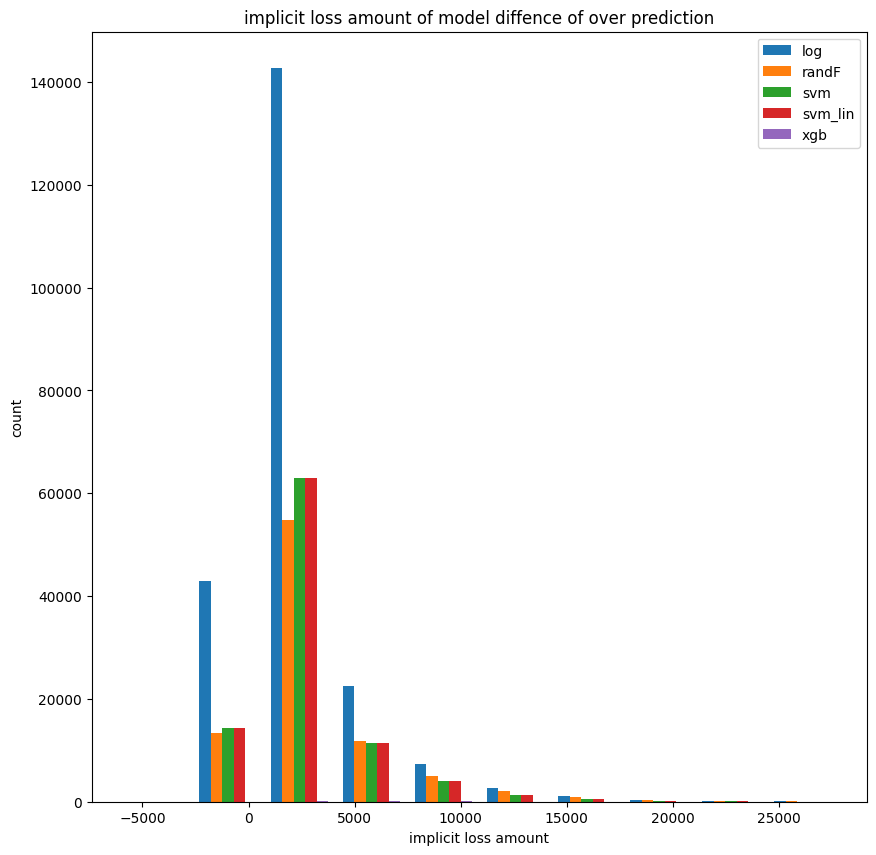

In [87]:
plt.figure(figsize=(10,10))

#plt.hist(dfLC_difference.loc[dfLC_difference["depvar"]==1]["loss_amnt"], bins=10)
plt.hist((diff_TP_log_dfLC_implicit["loss_amnt_implicit"], diff_TP_randF_dfLC_implicit["loss_amnt_implicit"], diff_TP_svm_dfLC_implicit["loss_amnt_implicit"], diff_TP_svm_dfLC_implicit["loss_amnt_implicit"], diff_TP_xgb_dfLC_implicit["loss_amnt_implicit"]), label=('log', 'randF', 'svm', 'svm_lin', 'xgb'), histtype='bar')
plt.xlabel('implicit loss amount')
plt.ylabel('count')
plt.legend()
plt.title("implicit loss amount of model diffence of over prediction")

plt.show()

In [88]:
# LC의 Implicit Loss는 알 수 없음

In [89]:
# logit의 Implicit Loss
depvar_update_log = (dfLC["log_pred"] == 1) & (dfLC["depvar"] == 0)
depvar_update_log = depvar_update_log.astype(int)
implicit_lossOflog = (depvar_update_log)*dfLC["loss_amnt_implicit"]
print("Implicit Loss of Logistic Regression")
implicit_lossOflog.sum()

Implicit Loss of Logistic Regression


537079657.553092

In [90]:
# xgb의 Implicit Loss
depvar_update_xgb = (dfLC["xgb_pred"] == 1) & (dfLC["depvar"] == 0)
depvar_update_xgb = depvar_update_xgb.astype(int)
implicit_lossOfxgb = (depvar_update_xgb)*dfLC["loss_amnt_implicit"]
print("Implicit Loss of XGBoost")
implicit_lossOfxgb.sum()

Implicit Loss of XGBoost


2704445.9010890005

In [91]:
# RandF의 Implicit Loss
depvar_update_randF = (dfLC["randF_pred"] == 1) & (dfLC["depvar"] == 0)
depvar_update_randF = depvar_update_randF.astype(int)
implicit_lossOfrandF = (depvar_update_randF)*dfLC["loss_amnt_implicit"]
print("Implicit Loss of Random Forest")
implicit_lossOfrandF.sum()

Implicit Loss of Random Forest


272959517.05750996

In [92]:
# svm의 Implicit Loss
depvar_update_svm = (dfLC["svm_pred"] == 1) & (dfLC["depvar"] == 0)
depvar_update_svm = depvar_update_svm.astype(int)
implicit_lossOfsvm = (depvar_update_svm)*dfLC["loss_amnt_implicit"]
print("Implicit Loss of SVM")
implicit_lossOfsvm.sum()

Implicit Loss of SVM


258646552.85280004

In [93]:
# svm_lin의 Implicit Loss
depvar_update_svm_lin = (dfLC["svm_lin_pred"] == 1) & (dfLC["depvar"] == 0)
depvar_update_svm_lin = depvar_update_svm_lin.astype(int)
implicit_lossOfsvm_lin = (depvar_update_svm_lin)*dfLC["loss_amnt_implicit"]
print("Implicit Loss of SVM_lin")
implicit_lossOfsvm_lin.sum()

Implicit Loss of SVM_lin


311688633.51069903

# Loss와 Implicit Loss 모두 이용한 비교
## 총 손실 = Risk로 표현

In [94]:
# Total Risk를 만들고, 예측이 틀린것들만 모아서 risk_model에 저장
dfLC["Total Risk"] = dfLC["loss_amnt"] + dfLC["loss_amnt_implicit"]

# Logistic Regression
risk_log = dfLC.loc[dfLC["depvar"]!=dfLC["log_pred"]]

# Random Forest
risk_randF = dfLC.loc[dfLC["depvar"]!=dfLC["randF_pred"]]

# SVM
risk_svm = dfLC.loc[dfLC["depvar"]!=dfLC["svm_pred"]]

# XGBoost
risk_xgb = dfLC.loc[dfLC["depvar"]!=dfLC["xgb_pred"]]

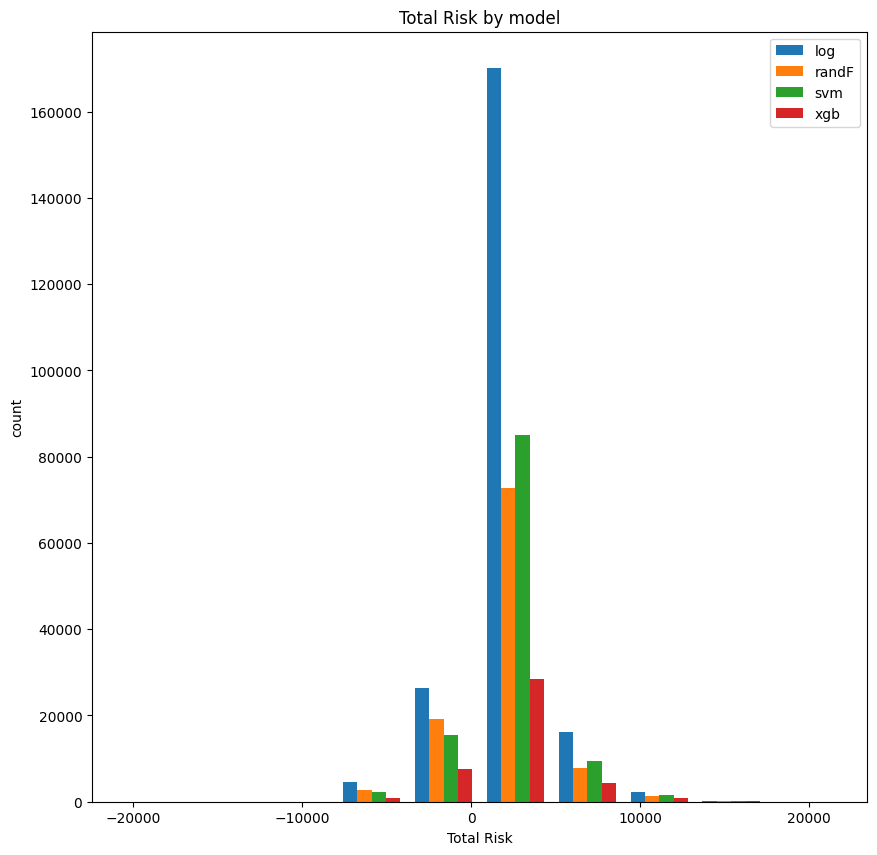

In [95]:
# risk_model graph
plt.figure(figsize=(10,10))

#plt.hist(dfLC_difference.loc[dfLC_difference["depvar"]==1]["loss_amnt"], bins=10)
plt.hist((risk_log["Total Risk"], risk_randF["Total Risk"], risk_svm["Total Risk"], risk_xgb["Total Risk"]), label=('log', 'randF', 'svm', 'xgb'), histtype='bar')
plt.xlabel('Total Risk')
plt.ylabel('count')
plt.legend()
plt.title("Total Risk by model")

plt.show()

In [104]:
# difference 반영
# diff_risk에 모두 0이 아니면서 모두 1이 아닌 경우 저장
diff_risk = pd.concat([dfLC_difference, dfLC_difference_implicit], axis=0)
diff_risk["Total Risk"] = diff_risk["loss_amnt"] + diff_risk["loss_amnt_implicit"]

# Logistic Regression
diff_risk_log = diff_risk.loc[dfLC["depvar"]!=dfLC["log_pred"]]

# Random Forest
diff_risk_randF = diff_risk.loc[dfLC["depvar"]!=dfLC["randF_pred"]]

# SVM
diff_risk_svm = diff_risk.loc[dfLC["depvar"]!=dfLC["svm_pred"]]

# SVM
diff_risk_svm_lin = diff_risk.loc[dfLC["depvar"]!=dfLC["svm_lin_pred"]]

# XGBoost
diff_risk_xgb = diff_risk.loc[dfLC["depvar"]!=dfLC["xgb_pred"]]

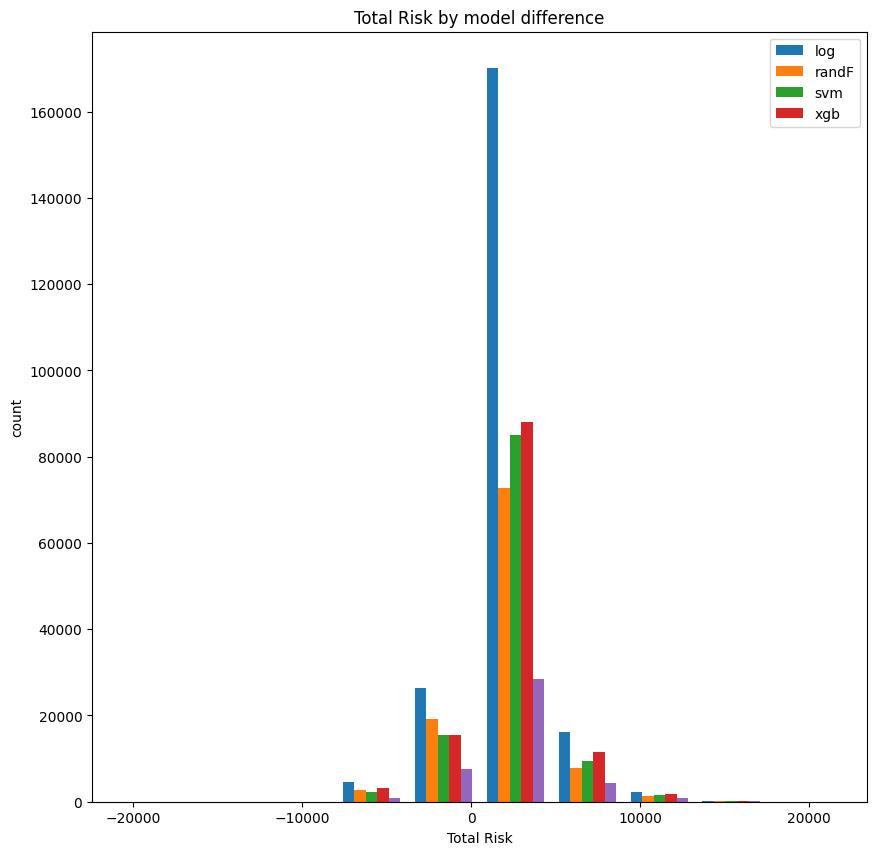

In [105]:
# diff_risk_model graph
plt.figure(figsize=(10,10))

#plt.hist(dfLC_difference.loc[dfLC_difference["depvar"]==1]["loss_amnt"], bins=10)
plt.hist((diff_risk_log["Total Risk"], diff_risk_randF["Total Risk"], diff_risk_svm["Total Risk"], diff_risk_svm_lin["Total Risk"], diff_risk_xgb["Total Risk"]), label=('log', 'randF', 'svm', 'xgb'), histtype='bar')
plt.xlabel('Total Risk')
plt.ylabel('count')
plt.legend()
plt.title("Total Risk by model difference")

plt.show()

In [101]:
print("Risk of LC (without Implicit Loss)")
print(lossOfLC.sum())
print("Risk of Logistic Regression")
print(lossOflog.sum() + implicit_lossOflog.sum())
print("Risk of XGBoost")
print(lossOfxgb.sum() + implicit_lossOfxgb.sum())
print("Risk of Random Forest")
print(lossOfrandF.sum() + implicit_lossOfrandF.sum())
print("Risk of SVM")
print(lossOfsvm.sum() + implicit_lossOfsvm.sum())
print("Risk of SVM_lin")
print(lossOfsvm_lin.sum() + implicit_lossOfsvm_lin.sum())

Risk of LC (without Implicit Loss)
298839515.232491
Risk of Logistic Regression
537079657.553092
Risk of XGBoost
298511068.29332
Risk of Random Forest
397369964.09962696
Risk of SVM
392177206.41637903
Risk of SVM_lin
414245263.05356205


In [ ]:
# 성희님께 : 이후내용은 수정 예정입니다.

# 최종모델인 Xgbboost에 Test data 학습

In [90]:
import xgboost as xgb

In [106]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# 추가학습 : validation data oversampling 반영
ros = RandomOverSampler(random_state=100)
over_X_initial_test, over_y_test = ros.fit_resample(X_initial_test, y_test)

new_data_over = xgb.DMatrix(data = over_X_initial_test, label = over_y_test)
xgb_model_over.update(train=new_data_over, iteration=10)


In [ ]:
# 추가학습 : validation data 그대로 반영
new_data = xgb.DMatrix(data = X_initial_test, label = y_test)
xgb_model.update(dtrain=new_data, iteration=10)

In [131]:
# test set 분할 처리
test_set = pd.read_stata('./lendingclub_test.dta')
X_TEST = preprocess_initial(test_set)
Y_TEST = preprocess_y(test_set)

eliminate start ...
eliminate complete.


,depvar
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
218579,0.0
218580,0.0
218581,1.0
218582,0.0


In [132]:
X_dfs = np.array_split(X_TEST, 10)
Y_dfs = np.array_split(Y_TEST, 10)

for i, df in enumerate(X_dfs):
    globals()[f"X_TEST_{i}"] = df

for i, df in enumerate(Y_dfs):
    globals()[f"Y_TEST_{i}"] = df

In [133]:
test_0 = xgb.DMatrix(data = X_TEST_0, label = Y_TEST_0)
test_1 = xgb.DMatrix(data = X_TEST_1, label = Y_TEST_1)
test_2 = xgb.DMatrix(data = X_TEST_2, label = Y_TEST_2)
test_3 = xgb.DMatrix(data = X_TEST_3, label = Y_TEST_3)
test_4 = xgb.DMatrix(data = X_TEST_4, label = Y_TEST_4)
test_5 = xgb.DMatrix(data = X_TEST_5, label = Y_TEST_5)
test_6 = xgb.DMatrix(data = X_TEST_6, label = Y_TEST_6)
test_7 = xgb.DMatrix(data = X_TEST_7, label = Y_TEST_7)
test_8 = xgb.DMatrix(data = X_TEST_8, label = Y_TEST_8)
test_9 = xgb.DMatrix(data = X_TEST_9, label = Y_TEST_9)

In [145]:
pred_probs_over_0 = xgb_model_over.predict(test_0)
pred_probs_over_1 = xgb_model_over.predict(test_1)
pred_probs_over_2 = xgb_model_over.predict(test_2)
pred_probs_over_3 = xgb_model_over.predict(test_3)
pred_probs_over_4 = xgb_model_over.predict(test_4)
pred_probs_over_5 = xgb_model_over.predict(test_5)
pred_probs_over_6 = xgb_model_over.predict(test_6)
pred_probs_over_7 = xgb_model_over.predict(test_7)
pred_probs_over_8 = xgb_model_over.predict(test_8)
pred_probs_over_9 = xgb_model_over.predict(test_9)

preds_over_0 = [1 if x > 0.5 else 0 for x in pred_probs_over_0]
preds_over_1 = [1 if x > 0.5 else 0 for x in pred_probs_over_1]
preds_over_2 = [1 if x > 0.5 else 0 for x in pred_probs_over_2]
preds_over_3 = [1 if x > 0.5 else 0 for x in pred_probs_over_3]
preds_over_4 = [1 if x > 0.5 else 0 for x in pred_probs_over_4]
preds_over_5 = [1 if x > 0.5 else 0 for x in pred_probs_over_5]
preds_over_6 = [1 if x > 0.5 else 0 for x in pred_probs_over_6]
preds_over_7 = [1 if x > 0.5 else 0 for x in pred_probs_over_7]
preds_over_8 = [1 if x > 0.5 else 0 for x in pred_probs_over_8]
preds_over_9 = [1 if x > 0.5 else 0 for x in pred_probs_over_9]


In [ ]:
pred_probs_0 = xgb_model.predict(test_0)
pred_probs_1 = xgb_model.predict(test_1)
pred_probs_2 = xgb_model.predict(test_2)
pred_probs_3 = xgb_model.predict(test_3)
pred_probs_4 = xgb_model.predict(test_4)
pred_probs_5 = xgb_model.predict(test_5)
pred_probs_6 = xgb_model.predict(test_6)
pred_probs_7 = xgb_model.predict(test_7)
pred_probs_8 = xgb_model.predict(test_8)
pred_probs_9 = xgb_model.predict(test_9)

preds_0 = [1 if x > 0.5 else 0 for x in pred_probs_0]
preds_1 = [1 if x > 0.5 else 0 for x in pred_probs_1]
preds_2 = [1 if x > 0.5 else 0 for x in pred_probs_2]
preds_3 = [1 if x > 0.5 else 0 for x in pred_probs_3]
preds_4 = [1 if x > 0.5 else 0 for x in pred_probs_4]
preds_5 = [1 if x > 0.5 else 0 for x in pred_probs_5]
preds_6 = [1 if x > 0.5 else 0 for x in pred_probs_6]
preds_7 = [1 if x > 0.5 else 0 for x in pred_probs_7]
preds_8 = [1 if x > 0.5 else 0 for x in pred_probs_8]
preds_9 = [1 if x > 0.5 else 0 for x in pred_probs_9]

In [146]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(10):
    # 예측값 계산
    xgb_pred = globals()[f"preds_over_{i}"]
    Y_TEST = globals()[f"Y_TEST_{i}"]
    conf_mat = confusion_matrix(Y_TEST, xgb_pred)
    
    # 평가지표 계산
    accuracy = accuracy_score(Y_TEST, xgb_pred)
    precision = precision_score(Y_TEST, xgb_pred, average='macro')
    recall = recall_score(Y_TEST, xgb_pred, average='macro')
    f1 = f1_score(Y_TEST, xgb_pred, average='macro')
    auc = roc_auc_score(Y_TEST, xgb_pred)
    fpr, tpr, thresholds = roc_curve(Y_TEST, xgb_pred)
    
    # 결과 출력
    print(f"Results for test_set_{i}:")
    print("Confusion Matrix:\n", conf_mat)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    print("-" * 50)
    
    # 리스트에 추가
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)

# 평균값과 표준편차 계산
print("Average Metrics:")
print("Accuracy:", np.mean(accuracy_list), "(+/-", np.std(accuracy_list), ")")
print("Precision:", np.mean(precision_list), "(+/-", np.std(precision_list), ")")
print("Recall:", np.mean(recall_list), "(+/-", np.std(recall_list), ")")
print("F1 Score:", np.mean(f1_list), "(+/-", np.std(f1_list), ")")
print("AUC:", np.mean(auc_list), "(+/-", np.std(auc_list), ")")

Results for test_set_0:
Confusion Matrix:
 [[13856  4510]
 [ 1933  1560]]
Accuracy: 0.7052472665721213
Precision: 0.5672873206514701
Recall: 0.6005225241790499
F1 Score: 0.5688087135840934
AUC: 0.6005225241790499
--------------------------------------------------
Results for test_set_1:
Confusion Matrix:
 [[13799  4537]
 [ 1903  1620]]
Accuracy: 0.7053845098128917
Precision: 0.5709602006114904
Recall: 0.6061993155548753
F1 Score: 0.5727552191303933
AUC: 0.6061993155548753
--------------------------------------------------
Results for test_set_2:
Confusion Matrix:
 [[13857  4514]
 [ 1937  1551]]
Accuracy: 0.7048812845967336
Precision: 0.5665440433044533
Recall: 0.5994770393130577
F1 Score: 0.5679478912572742
AUC: 0.5994770393130577
--------------------------------------------------
Results for test_set_3:
Confusion Matrix:
 [[13839  4554]
 [ 1925  1541]]
Accuracy: 0.7036003476828766
Precision: 0.5653582559737257
Recall: 0.5985052691180057
F1 Score: 0.5663341419039152
AUC: 0.598505269118

In [142]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(10):
    # 예측값 계산
    xgb_pred = globals()[f"preds_{i}"]
    Y_TEST = globals()[f"Y_TEST_{i}"]
    conf_mat = confusion_matrix(Y_TEST, xgb_pred)
    
    # 평가지표 계산
    accuracy = accuracy_score(Y_TEST, xgb_pred)
    precision = precision_score(Y_TEST, xgb_pred, average='macro')
    recall = recall_score(Y_TEST, xgb_pred, average='macro')
    f1 = f1_score(Y_TEST, xgb_pred, average='macro')
    auc = roc_auc_score(Y_TEST, xgb_pred)
    fpr, tpr, thresholds = roc_curve(Y_TEST, xgb_pred)
    
    # 결과 출력
    print(f"Results for test_set_{i}:")
    print("Confusion Matrix:\n", conf_mat)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    print("-" * 50)
    
    # 리스트에 추가
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)

# 평균값과 표준편차 계산
print("Average Metrics:")
print("Accuracy:", np.mean(accuracy_list), "(+/-", np.std(accuracy_list), ")")
print("Precision:", np.mean(precision_list), "(+/-", np.std(precision_list), ")")
print("Recall:", np.mean(recall_list), "(+/-", np.std(recall_list), ")")
print("F1 Score:", np.mean(f1_list), "(+/-", np.std(f1_list), ")")
print("AUC:", np.mean(auc_list), "(+/-", np.std(auc_list), ")")


Results for test_set_0:
Confusion Matrix:
 [[18338    28]
 [ 3458    35]]
Accuracy: 0.8405233542248044
Precision: 0.6984512958544891
Recall: 0.5042477419174622
F1 Score: 0.4664432865791184
AUC: 0.5042477419174622
--------------------------------------------------
Results for test_set_1:
Confusion Matrix:
 [[18298    38]
 [ 3489    34]]
Accuracy: 0.8386476966009424
Precision: 0.6560404267580565
Recall: 0.5037892199552281
F1 Score: 0.4655052334377769
AUC: 0.5037892199552281
--------------------------------------------------
Results for test_set_2:
Confusion Matrix:
 [[18342    29]
 [ 3456    32]]
Accuracy: 0.8405691019717279
Precision: 0.683021754138972
Recall: 0.503797868499365
F1 Score: 0.465637401617501
AUC: 0.5037978684993649
--------------------------------------------------
Results for test_set_3:
Confusion Matrix:
 [[18343    50]
 [ 3441    25]]
Accuracy: 0.8402946154901871
Precision: 0.5876866813563472
Recall: 0.5022472500373254
F1 Score: 0.46361489775155273
AUC: 0.50224725003732